<a href="https://colab.research.google.com/github/pranavrao145/house-median-value-prediction/blob/master/house-median-value-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn import preprocessing

In [22]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
raw_dataset = pd.read_csv('/content/drive/MyDrive/Datasets/housing.csv', names=column_names, delimiter=r"\s+")

In [23]:
np.shape(raw_dataset)

(506, 14)

In [24]:
raw_dataset.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [25]:
raw_dataset.isnull().values.any()

False

# Outliers

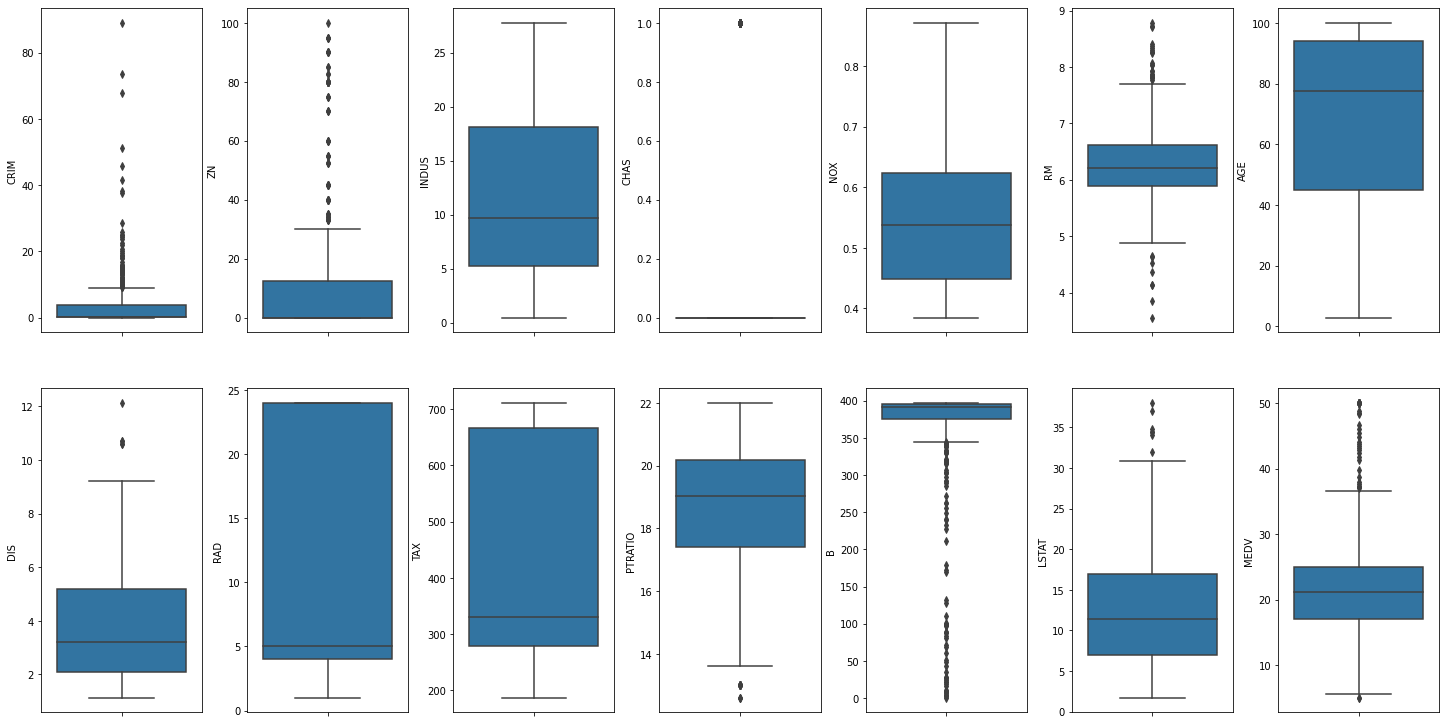

In [26]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in raw_dataset.items():
    sns.boxplot(y=k, data=raw_dataset, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Columns like CRIM, ZN, RM, B, and LSTAT seem to have outliers. According to a note on the original dataset, MEDV is censored at 50.0, which means that any rows with MEDV greater than or equal to 50.0 will not be helpful in our analysis:

In [27]:
raw_dataset = raw_dataset[~(raw_dataset['MEDV'] >= 50.0)]

# Distributions

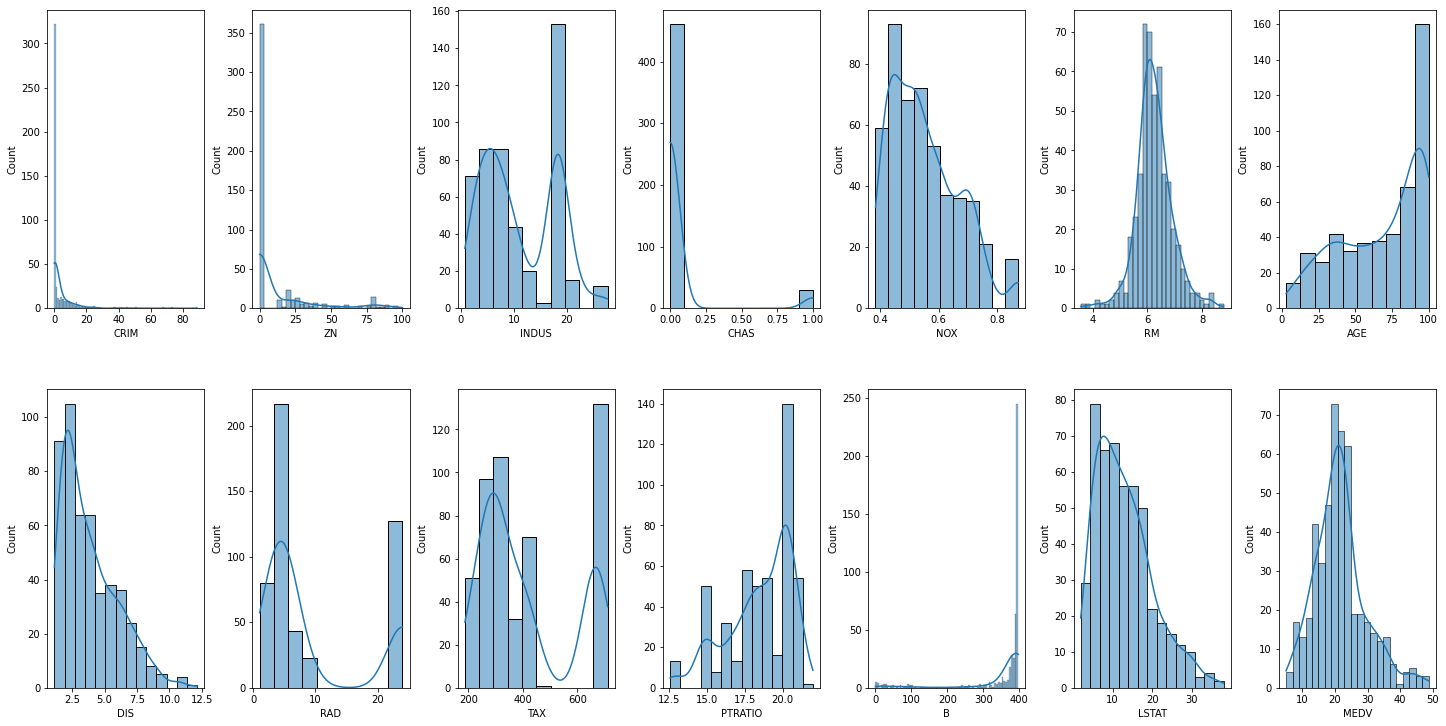

In [28]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in raw_dataset.items():
    sns.histplot(v, ax=axs[index], kde=True)
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

CRIM, ZN, and B have heavily skewed distributions. CHAS is a discrete variable.

# Correlation

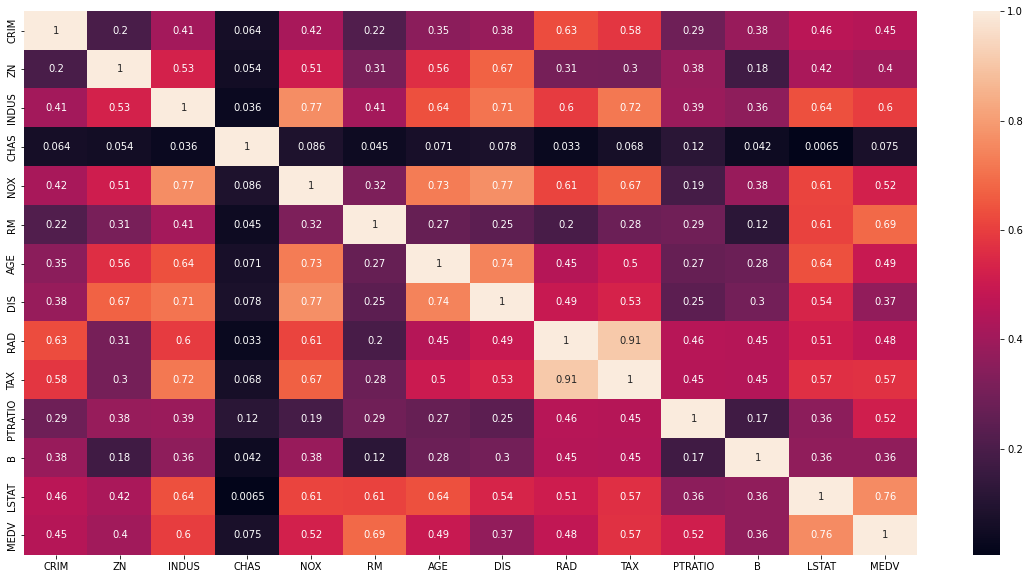

In [29]:
plt.figure(figsize=(20, 10))
sns.heatmap(raw_dataset.corr().abs(), annot=True)

It seems LSTAT, INDUS, RM, TAX, and PTRATIO have a correlation score of more than 0.45 against MEDV.

TAX and RAD are highly corrleated, so we can drop RAD as that doesn't have as much correlation to MEDV and is just an extra dimension.

# Refined Data
Plotting columns data against MEDV, except for those with the skewed distributions and RAD.

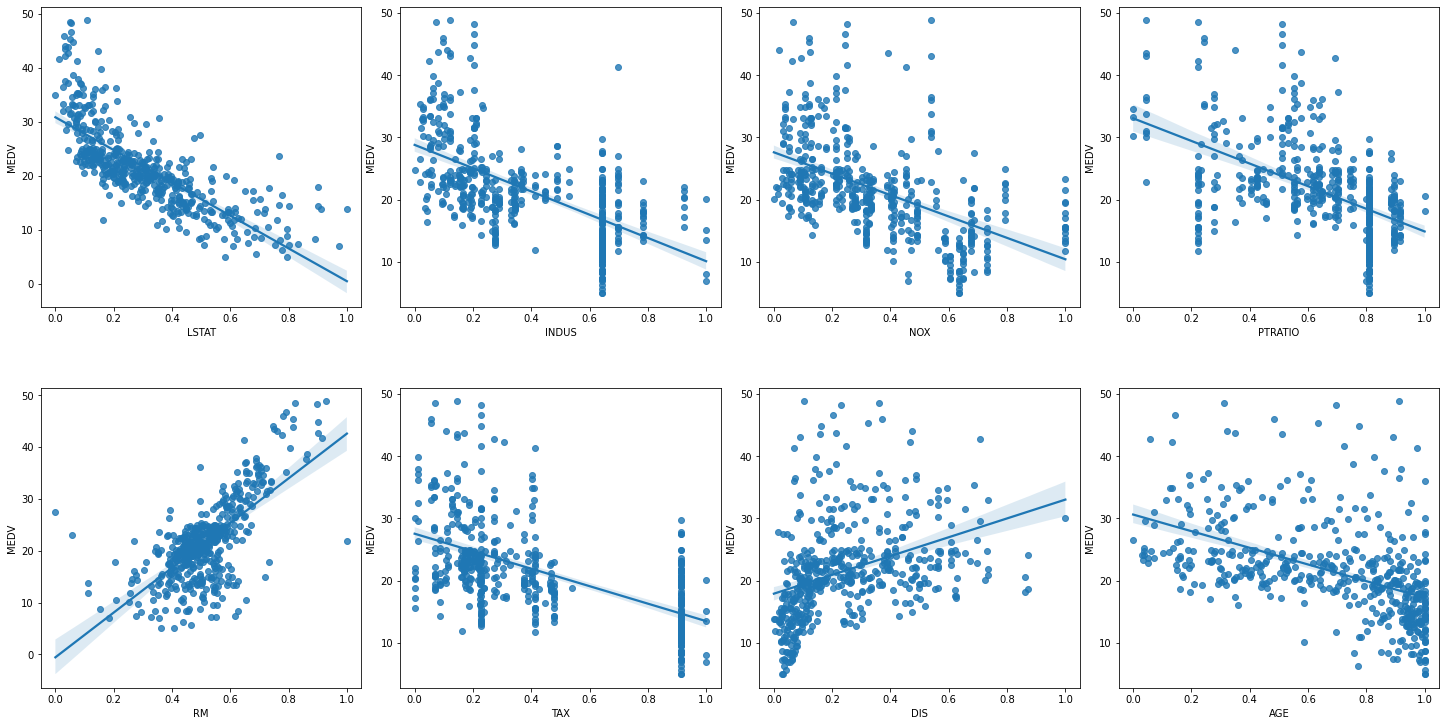

In [30]:
# To scale columns
min_max_scaler = preprocessing.MinMaxScaler()

column_sels = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']

x = raw_dataset.loc[:,column_sels]
y = raw_dataset['MEDV']

x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))

axs = axs.flatten()

for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=x[k], ax=axs[i])

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Now using log transformation to reduce skew beyond 0.3:

In [31]:
y =  np.log1p(y)
for col in x.columns:
    if np.abs(x[col].skew()) > 0.3:
        x[col] = np.log1p(x[col])

# Trying out Different Models
We will try out several models here to figure out which one will yield the best results for this data. We will be using K-Fold cross validation scoring, so we will not split the data into train and test to begin with.

In [32]:
all_scores = {} # to store the scores for each model so we can compare

## Linear Regression

We will first try linear regression with and without L2 regularization:

In [33]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=10)
min_max_scaler = preprocessing.MinMaxScaler()

x_scaled = min_max_scaler.fit_transform(x)

# Without L2

linear_regression = LinearRegression()
scores = cross_val_score(linear_regression, x_scaled, y, cv=kf, scoring="neg_mean_squared_error")

all_scores['LinearRegression'] = scores

# With L2

linear_ridge = Ridge()
scores = cross_val_score(linear_ridge, x_scaled, y, cv=kf, scoring="neg_mean_squared_error")

all_scores['Ridge'] = scores

## Non-Linear Regressors

Next, we will try out some non-linear regressors (SVM, Decision Tree, K Nearest Neighbours). We will use GridSearchCV for hyperparameter tuning.

### SVR

In [34]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svm = SVR(C=1.0, gamma=1.0)

# gridsearch_svm = GridSearchCV(svm, cv=kf, param_grid = { "C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5) }) # trying C values 1 to 1000 and gamma from -2 to 2
# gridsearch_svm.fit(x_scaled, y)

# print(gridsearch_svm.best_params_)

scores = cross_val_score(svm, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')

all_scores['SVR'] = scores

### Decision Tree

In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

desc_tr = DecisionTreeRegressor(max_depth=4)

# gridsearch_desc_tr = GridSearchCV(desc_tr, cv=kf, param_grid = { "max_depth": range(1, 8) }) # trying max depth values from 1 to 7, inclusive
# gridsearch_desc_tr.fit(x_scaled, y)

# print(gridsearch_desc_tr.best_params_)

scores = cross_val_score(desc_tr, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')

all_scores['DecisionTreeRegressor'] = scores

### K Nearest Neighbours

In [36]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=7)


# gridsearch_knn = GridSearchCV(knn, cv=kf, param_grid = { "n_neighbors": range(2, 8) }) # trying n neighbors values from 2 to 7, inclusive
# gridsearch_knn.fit(x_scaled, y)

# print(gridsearch_knn.best_params_)

scores = cross_val_score(knn, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')

all_scores['KNeighborsRegressor'] = scores

## Ensemble Regressors
We will also try an ensemble regressor, the Gradient Boosting Regressor.

### Gradient Booster

In [37]:
from sklearn.ensemble import GradientBoostingRegressor

grad_boost = GradientBoostingRegressor(learning_rate=0.05, max_depth=2, min_samples_leaf=9, n_estimators=100)

# parameters = {'n_estimators':[100, 200], 'learning_rate': [0.1,0.05,0.02], 'max_depth':[2, 4,6], 'min_samples_leaf':[3,5,9]}

# gridsearch_grad_boost = GridSearchCV(grad_boost, cv=kf, param_grid=parameters) 
# gridsearch_grad_boost.fit(x_scaled, y)

# print(gridsearch_grad_boost.best_params_)

scores = cross_val_score(grad_boost, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')

all_scores['GradientBoostingRegressor'] = scores

# Results

Here is a box plot that shows how each of the models performed:

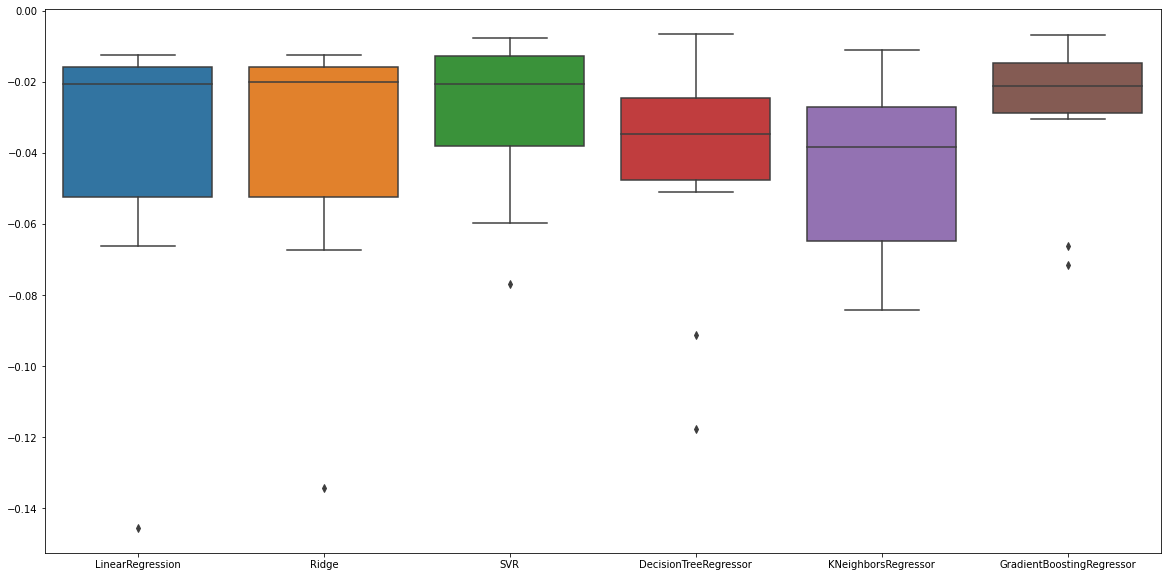

In [38]:
plt.figure(figsize=(20, 10))
all_scores = pd.DataFrame(all_scores)

sns.boxplot(data=all_scores)

# Results
According to the above box plot, the DecisionTree and the GradientBoosting Regressors gave the best results, with the following MSE and standard deviation:

In [39]:
dec_tree_scores = all_scores['DecisionTreeRegressor']
gb_scores = all_scores['GradientBoostingRegressor']

print(f"Decision Tree:\nMSE: {round(dec_tree_scores.mean(), 2)}\nSTD: {round(dec_tree_scores.std(), 2)}")
print()
print(f"Gradient Boosting:\nMSE: {round(gb_scores.mean(), 2)}\nSTD: {round(gb_scores.std(), 2)}")


Decision Tree:
MSE: -0.04
STD: 0.03

Gradient Boosting:
MSE: -0.03
STD: 0.02
